In [ ]:
pip install transformers torch sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install datasets


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Splits data into test and train data
def DataSplitter(data_loader):
    train_size = int(0.7 * len(data_loader))
    test_size = len(data_loader) - train_size
    train_dataset, test_dataset = random_split(data_loader, [train_size, test_size])

    print("Train size: " + str(len(train_dataset)))
    print("Test size: " + str(len(test_dataset)))
    print("[+] Training/Testing Set Split")

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_dataloader, test_dataloader, test_dataset

# Define the function to convert specific labels to group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, latent_vectors=None):
        self.data = pd.read_csv(csv_file)

        # Prepare feature matrix

        # Prepare feature matrix X
        self.X = self.data.drop([self.data.columns[0], self.data.columns[1], self.data.columns[2]], axis=1).values
        self.latent_vectors = latent_vectors

        # Prepare binary labels
        self.y_binary = self.data[self.data.columns[1]].values

        # Prepare specific labels
        self.y_specific = self.data[self.data.columns[2]].values

        # Prepare group labels
        self.y_group = self.data[self.data.columns[2]].apply(convert_to_group).values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Concatenate original features with the latent vector
        inputs_with_latent = torch.cat((
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.latent_vectors[idx], dtype=torch.float32)
        ), dim=0)

        binary_label = torch.tensor(self.y_binary[idx], dtype=torch.float32)
        group_label = torch.tensor(self.y_group[idx], dtype=torch.long)
        specific_label = torch.tensor(self.y_specific[idx], dtype=torch.long)

        return inputs_with_latent, binary_label, group_label, specific_label




Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Splits data into test and train data
def DataSplitter(data_loader):
    train_size = int(0.7 * len(data_loader))
    test_size = len(data_loader) - train_size
    train_dataset, test_dataset = random_split(data_loader, [train_size, test_size])

    print("Train size: " + str(len(train_dataset)))
    print("Test size: " + str(len(test_dataset)))
    print("[+] Training/Testing Set Split")

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_dataloader, test_dataloader, test_dataset

# Define the function to convert specific labels to group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, latent_vectors=None):
        self.data = pd.read_csv(csv_file)

        # Prepare feature matrix X
        self.X = self.data.drop([self.data.columns[0], self.data.columns[1], self.data.columns[2]], axis=1).values
        self.latent_vectors = latent_vectors

        # Prepare binary labels
        self.y_binary = self.data[self.data.columns[1]].values

        # Prepare specific labels
        self.y_specific = self.data[self.data.columns[2]].values

        # Prepare group labels
        self.y_group = self.data[self.data.columns[2]].apply(convert_to_group).values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs = torch.tensor(self.X[idx], dtype=torch.float32)

        # Concatenate original features with the latent vector if provided
        if self.latent_vectors is not None:
            latent = torch.tensor(self.latent_vectors[idx], dtype=torch.float32)
            inputs_with_latent = torch.cat((inputs, latent), dim=0)
        else:
            inputs_with_latent = inputs

        binary_label = torch.tensor(self.y_binary[idx], dtype=torch.float32)
        group_label = torch.tensor(self.y_group[idx], dtype=torch.long)
        specific_label = torch.tensor(self.y_specific[idx], dtype=torch.long)

        return inputs_with_latent, binary_label, group_label, specific_label

import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # Use Sigmoid for normalized output in [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# Hyperparameters
input_dim = 30967  # Number of original features
latent_dim = 128   # Size of the latent vector
batch_size = 32
num_epochs = 50
learning_rate = 1e-3

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset from disk
csv_file = '/content/drive/MyDrive/RansomwareData.csv'
raw_dataset = CustomDataset(csv_file)

# DataLoader for the raw dataset
raw_data_loader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=True)

# Initialize the autoencoder
autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for batch in raw_data_loader:
        inputs, _, _, _ = batch
        inputs = inputs.to(device)

        # Forward pass
        latent, outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(raw_data_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Extract latent vectors for the entire dataset after training
autoencoder.eval()
latent_vectors = []
with torch.no_grad():
    for batch in DataLoader(raw_dataset, batch_size=batch_size, shuffle=False):
        inputs, _, _, _ = batch
        inputs = inputs.to(device)
        latent, _ = autoencoder(inputs)
        latent_vectors.append(latent.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)

# Create a new dataset with latent vectors
dataset_with_latent = CustomDataset(csv_file, latent_vectors=latent_vectors)

# Create DataLoader for the dataset with latent vectors
train_loader, test_loader, test_dataset = DataSplitter(dataset_with_latent)

# Test DataLoader
for batch in train_loader:
    inputs_with_latent, binary_labels, group_labels, specific_labels = batch
    print("Inputs with latent:", inputs_with_latent.shape)
    print("Binary Labels:", binary_labels.shape)
    print("Group Labels:", group_labels.shape)
    print("Specific Labels:", specific_labels.shape)
    break


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Epoch 1/50, Loss: 0.0274
Epoch 2/50, Loss: 0.0037
Epoch 3/50, Loss: 0.0037
Epoch 4/50, Loss: 0.0038
Epoch 5/50, Loss: 0.0038
Epoch 6/50, Loss: 0.0038
Epoch 7/50, Loss: 0.0038
Epoch 8/50, Loss: 0.0038
Epoch 9/50, Loss: 0.0038
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0037
Epoch 12/50, Loss: 0.0037
Epoch 13/50, Loss: 0.0038
Epoch 14/50, Loss: 0.0038
Epoch 15/50, Loss: 0.0038
Epoch 16/50, Loss: 0.0038
Epoch 17/50, Loss: 0.0038
Epoch 18/50, Loss: 0.0038
Epoch 19/50, Loss: 0.0038
Epoch 20/50, Loss: 0.0038
Epoch 21/50, Loss: 0.0038
Epoch 22/50, Loss: 0.0038
Epoch 23/50, Loss: 0.0038
Epoch 24/50, Loss: 0.0038
Epoch 25/50, Loss: 0.0048
Epoch 26/50, Loss: 0.0051
Epoch 27/50, Loss: 0.0052
Epoch 28/50, Loss: 0.0054
Epoch 29/50, Loss: 0.0054
Epoch 30/50, Loss: 0.0054
Epoch 31/50, Loss: 0.0054
Epoch 32/50, Loss: 0.0054
Epoch 33/50, Loss: 0.0052
Epoch 34/50, Loss: 0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaConfig, RobertaModel

class BinaryFeatureEmbedding(nn.Module):
    def __init__(self, num_features, embed_dim):
        super(BinaryFeatureEmbedding, self).__init__()
        self.linear = nn.Linear(num_features, embed_dim)

    def forward(self, x):
        return self.linear(x)

class CustomRoBERTaModel(nn.Module):
    def __init__(self, num_features, embed_dim, num_groups, num_specific):
        super(CustomRoBERTaModel, self).__init__()

        self.embedding = BinaryFeatureEmbedding(num_features, embed_dim)

        config = RobertaConfig(
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            max_position_embeddings=num_features,
            type_vocab_size=2,
            initializer_range=0.02,
            layer_norm_eps=1e-12
        )

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout with probability 0.5

        self.binary_output = nn.Linear(embed_dim, 1)
        self.specific_output = nn.Linear(embed_dim, num_specific)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        outputs = self.roberta(inputs_embeds=x)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)  # Apply dropout to the output

        binary_logits = self.binary_output(cls_output)
        binary_probs = torch.sigmoid(binary_logits)

        specific_logits = self.specific_output(cls_output)
        specific_probs = torch.softmax(specific_logits, dim=-1)

        return binary_probs, specific_probs

# Sample usage
num_features = 31095
embed_dim = 768
num_groups = 5  # Adjusted based on earlier grouping structure
num_specific = 12

model = CustomRoBERTaModel(num_features, embed_dim, num_groups, num_specific)
sample_input = torch.randint(0, 2, (8, num_features)).float()  # batch_size=8, num_features=30964
binary_output, specific_output = model(sample_input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Binary output shape:", binary_output.shape)
print("Specific output shape:", specific_output.shape)


Binary output shape: torch.Size([8, 1])
Specific output shape: torch.Size([8, 12])


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, data_loader, device):
    model.eval()
    binary_true = []
    binary_pred = []
    group_true = []
    group_pred = []
    specific_true = []
    specific_pred = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, binary_labels, group_labels, specific_labels = batch
            inputs = inputs.to(device)
            binary_labels = binary_labels.to(device)
            group_labels = group_labels.to(device)
            specific_labels = specific_labels.to(device)
            binary_probs, specific_probs = model(inputs)
            binary_preds = (binary_probs > 0.5).float()
            specific_preds = torch.argmax(specific_probs, dim=1)
            binary_true.extend(binary_labels.cpu().numpy())
            binary_pred.extend(binary_preds.cpu().numpy())
            specific_true.extend(specific_labels.cpu().numpy())
            specific_pred.extend(specific_preds.cpu().numpy())

    # Binary classification metrics
    binary_accuracy = accuracy_score(binary_true, binary_pred)
    binary_precision = precision_score(binary_true, binary_pred)
    binary_recall = recall_score(binary_true, binary_pred)
    binary_f1 = f1_score(binary_true, binary_pred)

    # Specific classification metrics
    specific_accuracy = accuracy_score(specific_true, specific_pred)
    specific_precision = precision_score(specific_true, specific_pred, average='weighted')
    specific_recall = recall_score(specific_true, specific_pred, average='weighted')
    specific_f1 = f1_score(specific_true, specific_pred, average='weighted')

    metrics = {
        "binary_accuracy": binary_accuracy,
        "binary_precision": binary_precision,
        "binary_recall": binary_recall,
        "binary_f1": binary_f1,
        "specific_accuracy": specific_accuracy,
        "specific_precision": specific_precision,
        "specific_recall": specific_recall,
        "specific_f1": specific_f1,
    }

    return metrics


In [ ]:
#PLOT

binary_acc = []
val_binary_acc = []
group_acc = []
val_group_acc = []
specific_acc = []
val_specific_acc = []

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import os


# Example usage
binary_loss_fn = nn.BCELoss()
specific_loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

writer = SummaryWriter(log_dir=os.path.join("runs", "exp1"))

best_val_loss = float('inf')
early_stopping_patience = 5
patience_counter = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, binary_labels, group_labels, specific_labels = batch
        optimizer.zero_grad()

        binary_probs, specific_probs = model(inputs)

        binary_loss = binary_loss_fn(binary_probs, binary_labels.unsqueeze(1))
        specific_loss = specific_loss_fn(specific_probs, specific_labels)

        loss = binary_loss + specific_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log epoch loss
    metrics = evaluate(model, train_loader, device)

    val_metrics = evaluate(model, test_loader, device)

    val_loss = sum(val_metrics.values())  # Sum of all validation metrics as a proxy for validation loss


    binary_acc.append(metrics['binary_accuracy'])
    val_binary_acc.append(val_metrics['binary_accuracy'])
    specific_acc.append(metrics['specific_accuracy'])
    val_specific_acc.append(val_metrics['specific_accuracy'])
    # Logging
    writer.add_scalar("Loss/train", epoch_loss/len(train_loader), epoch)
    writer.add_scalar("Loss/validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Binary", val_metrics['binary_accuracy'], epoch)
    writer.add_scalar("Accuracy/Specific", val_metrics['specific_accuracy'], epoch)
    print("*" * 32)
    print(metrics)
    print(val_metrics)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss/len(train_loader)}, Val Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is i

********************************
{'binary_accuracy': 0.6285178236397748, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.6285178236397748, 'specific_precision': 0.39503465463287907, 'specific_recall': 0.6285178236397748, 'specific_f1': 0.4851462463578907}
{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}
Epoch 1/20, Train Loss: 2.6966921301449047, Val Loss: 2.5839486383139842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is i

********************************
{'binary_accuracy': 0.6285178236397748, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.6285178236397748, 'specific_precision': 0.39503465463287907, 'specific_recall': 0.6285178236397748, 'specific_f1': 0.4851462463578907}
{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}
Epoch 2/20, Train Loss: 2.6798003911972046, Val Loss: 2.5839486383139842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is i

********************************
{'binary_accuracy': 0.6285178236397748, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.6285178236397748, 'specific_precision': 0.39503465463287907, 'specific_recall': 0.6285178236397748, 'specific_f1': 0.4851462463578907}
{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}
Epoch 3/20, Train Loss: 2.6693002266042374, Val Loss: 2.5839486383139842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is i

********************************
{'binary_accuracy': 0.6285178236397748, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.6285178236397748, 'specific_precision': 0.39503465463287907, 'specific_recall': 0.6285178236397748, 'specific_f1': 0.4851462463578907}
{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}
Epoch 4/20, Train Loss: 2.6787531095392563, Val Loss: 2.5839486383139842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is i

********************************
{'binary_accuracy': 0.6285178236397748, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.6285178236397748, 'specific_precision': 0.39503465463287907, 'specific_recall': 0.6285178236397748, 'specific_f1': 0.4851462463578907}
{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}
Epoch 5/20, Train Loss: 2.685208692270167, Val Loss: 2.5839486383139842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************************
{'binary_accuracy': 0.6285178236397748, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.6285178236397748, 'specific_precision': 0.39503465463287907, 'specific_recall': 0.6285178236397748, 'specific_f1': 0.4851462463578907}
{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}
Epoch 6/20, Train Loss: 2.6823046417797314, Val Loss: 2.5839486383139842
Early stopping triggered.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

print(val_metrics)


{'binary_accuracy': 0.5951859956236324, 'binary_precision': 0.0, 'binary_recall': 0.0, 'binary_f1': 0.0, 'specific_accuracy': 0.5951859956236324, 'specific_precision': 0.35424636938649456, 'specific_recall': 0.5951859956236324, 'specific_f1': 0.4441442820565926}


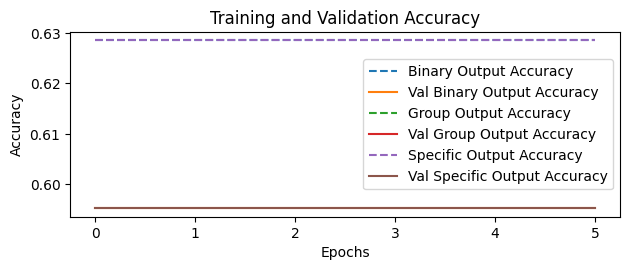

In [ ]:
import matplotlib.pyplot as plt
# Plot loss
# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(binary_acc, linestyle='--', label='Binary Output Accuracy')
plt.plot(val_binary_acc, label='Val Binary Output Accuracy')
plt.plot(group_acc, linestyle='--', label='Group Output Accuracy')
plt.plot(val_group_acc, label='Val Group Output Accuracy')
plt.plot(specific_acc, linestyle='--', label='Specific Output Accuracy')
plt.plot(val_specific_acc, label='Val Specific Output Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


KeyError: 'group_accuracy'

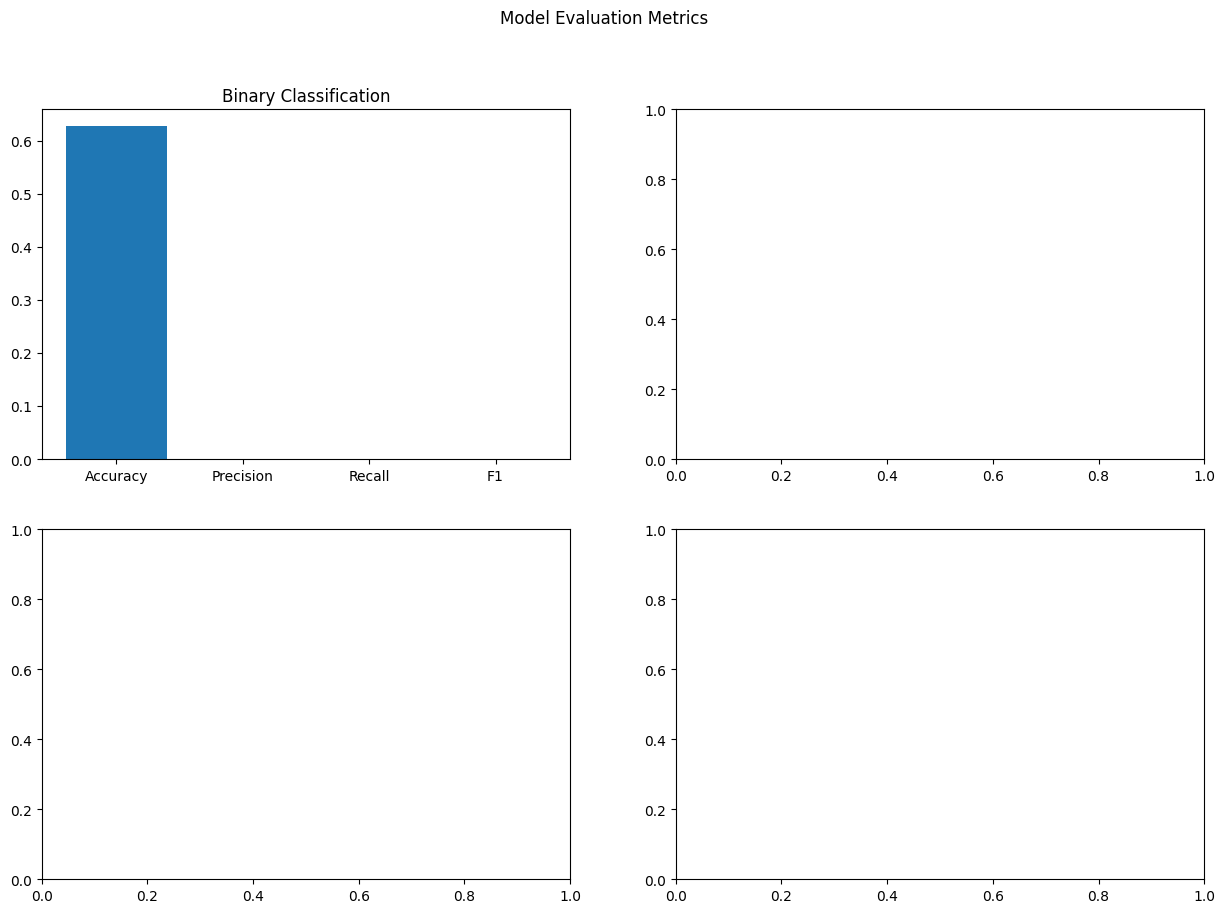

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics
def plot_metrics(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Evaluation Metrics')

    # Binary Classification Metrics
    axes[0, 0].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['binary_accuracy'], metrics['binary_precision'], metrics['binary_recall'], metrics['binary_f1']])
    axes[0, 0].set_title('Binary Classification')

    # Group Classification Metrics
    axes[0, 1].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['group_accuracy'], metrics['group_precision'], metrics['group_recall'], metrics['group_f1']])
    axes[0, 1].set_title('Group Classification')

    # Specific Classification Metrics
    axes[1, 0].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['specific_accuracy'], metrics['specific_precision'], metrics['specific_recall'], metrics['specific_f1']])
    axes[1, 0].set_title('Specific Classification')

    # Overall Metrics
    overall_accuracy = (metrics['binary_accuracy'] + metrics['group_accuracy'] + metrics['specific_accuracy']) / 3
    overall_precision = (metrics['binary_precision'] + metrics['group_precision'] + metrics['specific_precision']) / 3
    overall_recall = (metrics['binary_recall'] + metrics['group_recall'] + metrics['specific_recall']) / 3
    overall_f1 = (metrics['binary_f1'] + metrics['group_f1'] + metrics['specific_f1']) / 3

    axes[1, 1].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [overall_accuracy, overall_precision, overall_recall, overall_f1])
    axes[1, 1].set_title('Overall Metrics')

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)